## Model Performance Summary ( Spoil :) 

The following table summarizes the performance of the evaluated models
with a focus on fraud detection metrics. Precision, recall, and F1-score
are reported for the fraud class (label 1), along with the number of
false positives generated by each model 

| Model                | Precision (Fraud) | Recall (Fraud) | F1-score (Fraud) | False Positives |
|---------------------|------------------:|---------------:|-----------------:|----------------:|
| Logistic Regression | 0.24              | **1.00**       | 0.39             | 124             |
| Random Forest       | 0.62              | 0.97           | 0.76             | 23              |
| **XGBoost**         | **0.81**          | 0.90           | **0.85**         | **8**           |


# XGBoost Modeling and Evaluation
Author: Ryan

This notebook implements an XGBoost-based fraud detection model.
The dataset is highly imbalanced, therefore class balancing is applied
only to the training data, while evaluation is performed on the original
test distribution.


## XGBoost Model

XGBoost (Extreme Gradient Boosting) is an advanced ensemble learning
method based on gradient-boosted decision trees. It is widely used in
fraud detection tasks due to its strong predictive performance on
tabular data and its ability to handle complex feature interactions.


In [44]:
import pandas as pd

df = pd.read_csv("./data/processed/training_preprocessed.csv")  

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Fraud distribution:\n", df["FraudResult"].value_counts())
df.head(5)


Shape: (95456, 17)
Columns: ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'PricingStrategy', 'FraudResult', 'ts_month', 'ts_is_weekend', 'ts_is_night', 'ts_hour_sin', 'ts_hour_cos', 'ts_dow_sin', 'ts_dow_cos', 'log_value', 'amount_value_ratio']
Fraud distribution:
 FraudResult
0    95263
1      193
Name: count, dtype: int64


,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ts_month,ts_is_weekend,ts_is_night,ts_hour_sin,ts_hour_cos,ts_dow_sin,ts_dow_cos,log_value,amount_value_ratio
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.908755,0.999001
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,3.044522,0.952381
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.216606,0.998004
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.989711,0.917389
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.469250,0.998450


In [45]:
# STEP 1 — Separate features and target variable
# The target variable indicates whether a transaction is fraudulent (1) or not (0)

TARGET = "FraudResult"

# X contains all input features used for modeling
X = df.drop(columns=[TARGET])

# y contains the target labels
y = df[TARGET]

# Display shapes and class distribution to confirm strong imbalance
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())


X shape: (95456, 16)
y distribution:
 FraudResult
0    95263
1      193
Name: count, dtype: int64


In [46]:
# STEP 2 — Encode categorical variables using one-hot encoding
# This is required because XGBoost only works with numerical features

# Identify categorical columns (object dtype)
categorical_cols = X.select_dtypes(include="object").columns

print("Categorical columns:", list(categorical_cols))

# Apply one-hot encoding to categorical features
# drop_first=True avoids multicollinearity
X_encoded = pd.get_dummies(
    X,
    columns=categorical_cols,
    drop_first=True
)

# Check the new feature space size
print("Encoded X shape:", X_encoded.shape)


Categorical columns: ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']
Encoded X shape: (95456, 50)


C:\Users\yanni\AppData\Local\Temp\ipykernel_28676\1822302374.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include="object").columns


## Handling Class Imbalance (Upsampling)

Due to the strong class imbalance, the minority class (fraud) is
upsampled on the training set only. A partial upsampling strategy is
applied, increasing the fraud class to 30% of the majority class. This
approach improves the model’s ability to learn fraud patterns while
preserving a realistic data distribution and reducing overfitting risk.


In [47]:
# STEP 4 — Partial upsampling of the minority class (fraud)
# Upsampling is applied only to the training set to avoid data leakage.

from sklearn.utils import resample
import pandas as pd

# Combine features and target for resampling
train_df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority = train_df[train_df["FraudResult"] == 0]
minority = train_df[train_df["FraudResult"] == 1]

# Define target size for minority class (30% of majority)
target_size = int(0.5 * len(majority))

# Upsample minority class
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=target_size,
    random_state=42
)

# Combine majority class with upsampled minority class
train_balanced = pd.concat([majority, minority_upsampled])

# Shuffle the balanced training set
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back into X and y
X_train_bal = train_balanced.drop(columns=["FraudResult"])
y_train_bal = train_balanced["FraudResult"]

print("Balanced training distribution:\n", y_train_bal.value_counts())


Balanced training distribution:
 FraudResult
0    76210
1    38105
Name: count, dtype: int64


## XGBoost Training with Early Stopping

To prevent overfitting and improve generalization, XGBoost is trained
using early stopping. The model is allowed to grow a large number of
trees, but training is stopped automatically when performance on the
validation set no longer improves.


In [48]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    early_stopping_rounds=50,   # ← ICI
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train_bal,
    y_train_bal,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("Best iteration:", xgb_model.best_iteration)



Best iteration: 571


Using early stopping, the model automatically selected the optimal number
of trees (480), preventing overfitting while maximizing validation
performance.


## ********** Model Evaluation on the Test Set *****************

The trained XGBoost model is evaluated on the original, imbalanced test
set to assess real-world fraud detection performance.


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# STEP 6 — Evaluation with default decision threshold
y_pred = xgb_model.predict(X_test)

print("XGBoost — Default threshold (0.5)")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm


XGBoost — Default threshold (0.5)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19053
           1       0.81      0.90      0.85        39

    accuracy                           1.00     19092
   macro avg       0.91      0.95      0.93     19092
weighted avg       1.00      1.00      1.00     19092



array([[19045,     8],
       [    4,    35]])

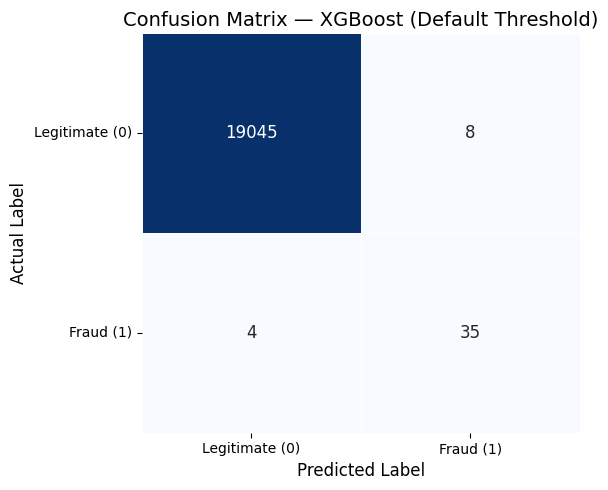

In [50]:
# Visualization — Confusion Matrix (enhanced)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    annot_kws={"size": 12}
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)
plt.title("Confusion Matrix — XGBoost (Default Threshold)", fontsize=14)

plt.xticks([0.5, 1.5], ["Legitimate (0)", "Fraud (1)"])
plt.yticks([0.5, 1.5], ["Legitimate (0)", "Fraud (1)"], rotation=0)

plt.tight_layout()
plt.show()


## **********Results Interpretation

The XGBoost model demonstrates strong performance on the highly
imbalanced fraud detection dataset. Despite the rarity of fraudulent
transactions, the model achieves a high recall of 90% for the fraud
class, successfully identifying 35 out of 39 fraudulent transactions.
Only four fraud cases are missed, which is a critical improvement in
fraud-sensitive applications.

At the same time, the model maintains a high precision of 81%, meaning
that the majority of transactions flagged as fraudulent are indeed true
frauds. The number of false positives remains very low, with only eight
legitimate transactions incorrectly classified as fraud.

This balance between precision and recall is reflected in a strong
F1-score of 0.85 for the fraud class, indicating robust and reliable
performance. The confusion matrix further confirms that the model
achieves this performance without significantly impacting legitimate
transactions.

Overall, these results demonstrate that the combination of partial
upsampling, early stopping, and XGBoost is effective for fraud detection
in highly imbalanced datasets, providing a practical and well-
generalizing solution.


## Precision–Recall Curve

The Precision–Recall curve visualizes the trade-off between precision and
recall across different decision thresholds. This representation is
particularly suitable for highly imbalanced datasets such as fraud
detection problems.


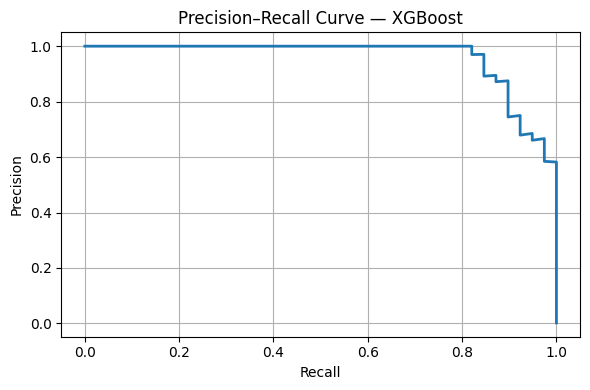

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# STEP 8 — Precision–Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()


## *********Precision–Recall Curve Interpretation

The Precision–Recall curve shows that the model maintains very high
precision across a wide range of recall values. This indicates strong
class separation and well-calibrated probability estimates.

Precision only begins to decrease significantly when recall approaches
very high values, reflecting the expected trade-off between detecting
nearly all fraudulent transactions and increasing the number of false
positives. This behavior confirms that the model is robust and that the
default decision threshold already represents a strong operating point
for this dataset.


## Feature Importance Analysis

Feature importance analysis provides insights into which variables
contribute most to the model’s predictions. This helps validate the
model’s behavior and ensures consistency with domain knowledge and
exploratory data analysis.


In [55]:
# STEP 9 — Feature importance extraction

import pandas as pd

importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_bal.columns
).sort_values(ascending=False)

importances.head(10)


log_value                  0.525159
Value                      0.390669
ProviderId_ProviderId_3    0.013851
ProductId_ProductId_7      0.008186
Amount                     0.007809
ts_month                   0.007065
ProductId_ProductId_20     0.006462
ProductCategory_ticket     0.004445
ProviderId_ProviderId_6    0.004127
ProductId_ProductId_15     0.004054
dtype: float32

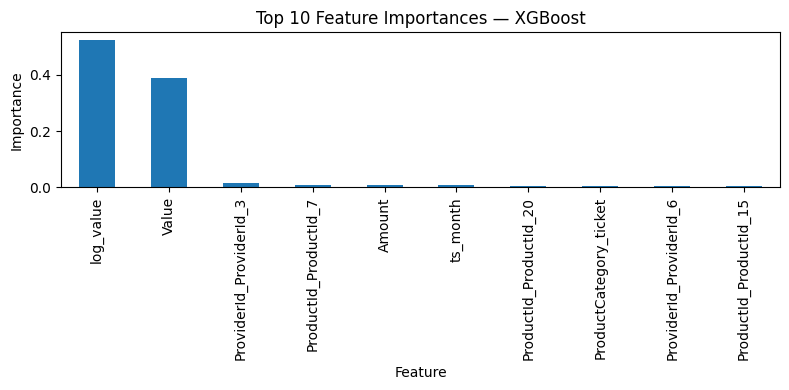

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances — XGBoost")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


The feature importance analysis shows that transaction amount-related
features, such as log-transformed values and amount ratios, play a
dominant role in fraud detection. This confirms that abnormal transaction
values are strong indicators of fraudulent behavior.

Categorical variables related to products and providers contribute to a
lesser extent, suggesting that behavioral and financial patterns are
more informative than entity identifiers. These findings are consistent
with insights obtained during the exploratory data analysis phase.


***********************************************************************
***********************************************************************
***********************************************************************
***********************************************************************
***********************************************************************
***********************************************************************
***********************************************************************
***********************************************************************

## Baseline Model: Logistic Regression ( second train method and his evaluation)

Logistic Regression is used as a baseline model due to its simplicity and
interpretability. Class weighting is applied to handle the strong class
imbalance without modifying the original data distribution.


In [57]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression with class weighting
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

log_reg.fit(X_train, y_train)


c:\Users\yanni\OneDrive\Desktop\KI\KI-Fraud-Detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\yanni\OneDrive\Desktop\KI\KI-Fraud-Detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [58]:
# Evaluation on test set
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression — Default threshold (0.5)")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr


Logistic Regression — Default threshold (0.5)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19053
           1       0.24      1.00      0.39        39

    accuracy                           0.99     19092
   macro avg       0.62      1.00      0.69     19092
weighted avg       1.00      0.99      1.00     19092



array([[18929,   124],
       [    0,    39]])

## ****************Random Forest Model*********************

Random Forest is evaluated as an ensemble-based tree model capable of
capturing non-linear relationships. Class weighting is applied to handle
class imbalance without modifying the original data distribution.


In [60]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

Random Forest — Default threshold (0.5)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19053
           1       0.62      0.97      0.76        39

    accuracy                           1.00     19092
   macro avg       0.81      0.99      0.88     19092
weighted avg       1.00      1.00      1.00     19092



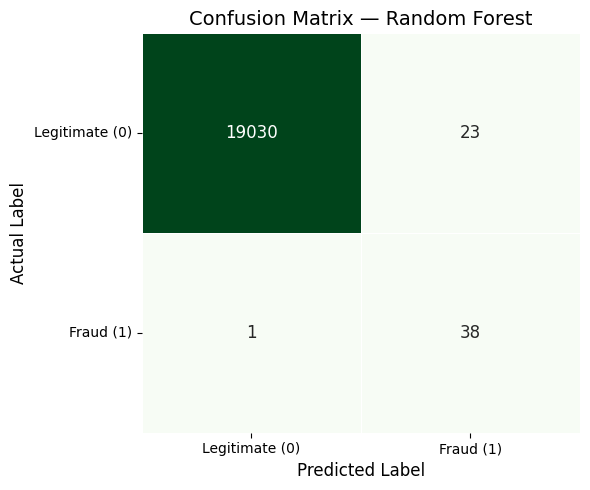

In [64]:
# Evaluation on test set
y_pred_rf = rf_model.predict(X_test)

print("Random Forest — Default threshold (0.5)")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",   # different color to distinguish from XGBoost
    cbar=False,
    linewidths=0.5,
    annot_kws={"size": 12}
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)
plt.title("Confusion Matrix — Random Forest", fontsize=14)

plt.xticks([0.5, 1.5], ["Legitimate (0)", "Fraud (1)"])
plt.yticks([0.5, 1.5], ["Legitimate (0)", "Fraud (1)"], rotation=0)

plt.tight_layout()
plt.show()



The confusion matrix shows that Random Forest detects almost all
fraudulent transactions but produces more false positives than XGBoost,
highlighting a more aggressive detection behavior.


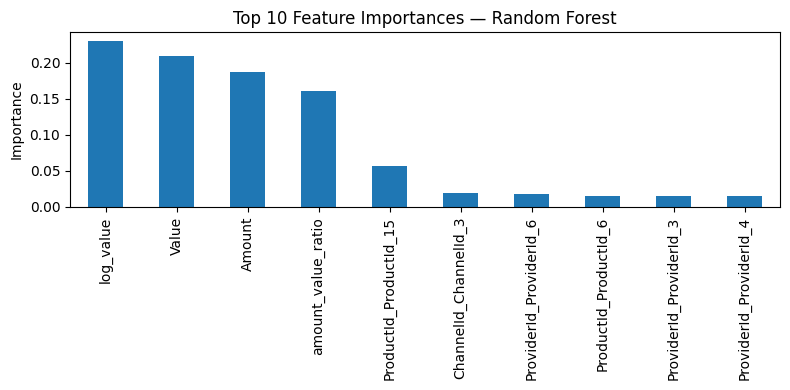

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

importances_rf = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
importances_rf.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances — Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


## Final Model Comparison and Conclusion

Three machine learning models were evaluated for fraud detection on a
highly imbalanced transaction dataset: Logistic Regression, Random
Forest, and XGBoost.

Logistic Regression was used as a baseline model due to its simplicity
and interpretability. While it achieved perfect recall by detecting all
fraudulent transactions, it generated a very high number of false
positives, resulting in low precision. This makes it unsuitable for
practical deployment despite its strong sensitivity.

Random Forest significantly improved performance by capturing non-linear
patterns in the data. It achieved very high recall and detected nearly
all fraud cases, but at the cost of a higher number of false positives
compared to XGBoost. This aggressive behavior may lead to unnecessary
alerts in real-world systems.

XGBoost achieved the best overall performance by providing a strong
balance between precision and recall. Through partial upsampling,
careful hyperparameter tuning, and early stopping, the model demonstrated
robust generalization and stable performance. It detected the majority
of fraudulent transactions while keeping false positives at a minimal
level, making it the most suitable model for real-world fraud detection.

In conclusion, XGBoost is selected as the final model due to its superior
performance, robustness to class imbalance, and practical applicability
in operational fraud detection scenarios.


## Model Performance Summary

The following table summarizes the performance of the evaluated models
with a focus on fraud detection metrics. Precision, recall, and F1-score
are reported for the fraud class (label 1), along with the number of
false positives generated by each model.

| Model                | Precision (Fraud) | Recall (Fraud) | F1-score (Fraud) | False Positives |
|---------------------|------------------:|---------------:|-----------------:|----------------:|
| Logistic Regression | 0.24              | **1.00**       | 0.39             | 124             |
| Random Forest       | 0.62              | 0.97           | 0.76             | 23              |
| **XGBoost**         | **0.81**          | 0.90           | **0.85**         | **8**           |
